In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random

In [44]:
# ---------------------------- LOAD OLIVIETTA DATASET ---------------------------- #

lfw_people = fetch_olivetti_faces(data_home='D:\Senior II\Image Processing\Project\Datasets/Olivietta Dataset', shuffle=True, random_state=47)

In [45]:
images = lfw_people.images
print('Images shape:',images.shape)

total_images, height, width = images.shape
print(f'Each image has size: {height} x {width}')

print(70* '-')

n_features = height*width
print(f'N^2 = n_features = h x w = {n_features}')

print(70* '-')

y = lfw_people.target
print('y has shape:', y.shape)

num_people = np.max(y) + 1
print('Number of people =', num_people)

Images shape: (400, 64, 64)
Each image has size: 64 x 64
----------------------------------------------------------------------
N^2 = n_features = h x w = 4096
----------------------------------------------------------------------
y has shape: (400,)
Number of people = 40


In [46]:
#----------------------- CREATE PEOPLE DICTIONARY -----------------------#

# Key: person ID
# Value: List of all person images indices
person_image_dict = dict()

for image_index in range(total_images):
    if (y[image_index] not in person_image_dict.keys()):
        person_image_dict[y[image_index]] = [image_index]
    else:
        person_image_dict[y[image_index]].append(image_index)

In [47]:
train_images = []
test_images = []
y_train = []
y_test = []

# guarantee that each person has at least 1 image in test set
for image_index_lst in person_image_dict.values():
    total_size = len(image_index_lst)
    size_train = int(0.8 * total_size)
    for index in range(len(image_index_lst)):
        image = images[image_index_lst[index]]
        label = y[image_index_lst[index]]
        if (index < size_train):
            train_images.append(image)
            y_train.append(label)
        else:
            test_images.append(image)
            y_test.append(label)
    

train_images = np.array(train_images)
test_images = np.array(test_images)
y_train = np.array(y_train)
y_test = np.array(y_test)

print('Train images shape:', train_images.shape)
print('Test images shape:', test_images.shape)

m = train_images.shape[0]
m_test = test_images.shape[0]
print(70* '-')
print('Number of train images:', m)
print('Number of test images:', m_test)


Train images shape: (320, 64, 64)
Test images shape: (80, 64, 64)
----------------------------------------------------------------------
Number of train images: 320
Number of test images: 80


In [48]:
images = lfw_people.images
print('Images shape:',images.shape)

total_images, height, width = images.shape
print(f'Each image has size: {height} x {width}')

print(70* '-')

m = int(total_images * 0.8)
print('M = Number of examples = ', m)

m_test = total_images - m
print('M_test = Number of test examples = ', m_test)

train_images = images[:int(m)]
print('Train images shape:', train_images.shape)

test_images = images[int(m):]
print('Test images shape:', test_images.shape)

n_features = height*width
print(f'N^2 = n_features = h x w = {n_features}')

print(70* '-')

y = lfw_people.target
print('y has shape:', y.shape)

y_train = y[:int(m)]
print('y_train has shape:', y_train.shape)

y_test = y[int(m):]
print('y_test has shape:', y_test.shape)

# target_names = lfw_people.target_names
num_people = np.max(y) + 1
print('Number of people =', num_people)

Images shape: (400, 64, 64)
Each image has size: 64 x 64
----------------------------------------------------------------------
M = Number of examples =  320
M_test = Number of test examples =  80
Train images shape: (320, 64, 64)
Test images shape: (80, 64, 64)
N^2 = n_features = h x w = 4096
----------------------------------------------------------------------
y has shape: (400,)
y_train has shape: (320,)
y_test has shape: (80,)
Number of people = 40


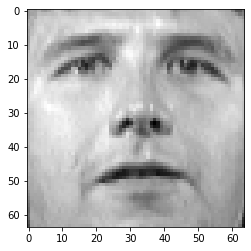

In [49]:
# ------------------ VIEW RANDOM IMAGE ------------------ #
index = int(random.random() * m)
index = 0
image = images[index,:,:]
# name = target_names[y[index]]

# print(name)
plt.imshow(image, cmap='gray')
plt.show()

In [50]:
# --------------------- GET FLATTEN IMAGES --------------------- #

# Flatten images array
# Each column is an image

# N^2 * M
flattened_images = train_images.reshape(m, -1).T

# N^2 * M_test
flattened_test_images = test_images.reshape(m_test, -1).T

print(f'Shape of training images after flattening: {flattened_images.shape}')
print(f'Shape of test images after flattening: {flattened_test_images.shape}')

Shape of training images after flattening: (4096, 320)
Shape of test images after flattening: (4096, 80)


Average image has shape: (4096, 1)


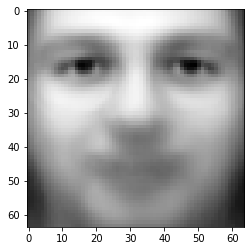

In [51]:
# ----------------- CALCULATE AVERAGE IMAGE ----------------- #

# In all corresponding pixels in all images, we calculate the average

# N^2 * 1
average_image = np.mean(flattened_images, axis = 1)[:,np.newaxis]

print(f'Average image has shape: {average_image.shape}')
plt.imshow(average_image.reshape(height,width), cmap='gray')
plt.show()

In [52]:
#-------------------------------- GET DIFFERENCE IMAGES --------------------------------#

# Subtract the average image from all images
# This is done to remove the average face from all images
# N^2 * M
difference_images = flattened_images - average_image

print(f'Shape after subtracting average face: {difference_images.shape}')


Shape after subtracting average face: (4096, 320)


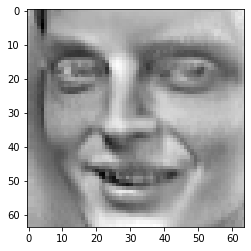

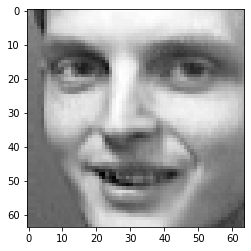

In [53]:
# --------------------- SHOW ONE DIFFERENCE IMAGE AND COMPARE TO ORIGINAL --------------------- #

index = int(random.random() * m)

plt.imshow(difference_images[:,index].reshape(height, width), cmap='gray')
plt.show()

# Print original image
plt.imshow(train_images[index,:,:], cmap='gray')
plt.show()

In [54]:
#--------------------- GET COVARIANCE MATRIX --------------------- #

# C = A * A^T where A = difference_images

# N^2 * M
A = difference_images

if (m > n_features):
    # N^2 * N^2
    covariance_matrix = np.matmul(difference_images, difference_images.T)
    print('Shape of covariance matrix = N^2 * N^2 = ', covariance_matrix.shape)
    
else:
    # M * M
    covariance_matrix = np.matmul(difference_images.T, difference_images)
    print('Shape of covariance matrix = M * M = ', covariance_matrix.shape)

Shape of covariance matrix = M * M =  (320, 320)


In [55]:
# --------------------------------- GET EIGENVALUES AND EIGENVECTORS --------------------------------- #
# M eigenvalues and M eigenvectors
# where M is the number of examples

eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of eigenvectors before matrix multiplication:', eigenvectors.shape)

# Try to remove
eigenvectors = np.matmul(difference_images, eigenvectors)

print('Shape of eigenvectors after matrix multiplication:', eigenvectors.shape)

Shape of eigenvalues: (320,)
Shape of eigenvectors before matrix multiplication: (320, 320)
Shape of eigenvectors after matrix multiplication: (4096, 320)


In [56]:
# --------------------------------- NORMALIZE EIGENVECTORS --------------------------------- #

eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

print('Shape of eigenvectors after normalization:', eigenvectors.shape)

Shape of eigenvectors after normalization: (4096, 320)


In [57]:
# ------------------------ SORT EIGENVECTORS ------------------------ #

# Get top K eigenvectors
indices_of_top_eigenvalues = np.argsort(-eigenvalues)
eigenvalues = eigenvalues[indices_of_top_eigenvalues]
eigenvectors = eigenvectors[:, indices_of_top_eigenvalues]

In [58]:
# --------------------------------- CALCULATE K --------------------------------- #

#Try to understand

#Calculate the number of components to preserve 95% of the variance
variance = 0.95
K = m
for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
    if eigen_value_cumsum > variance:
        K = ii
        break

print(f'Number of components to preserve {variance*100}% of the variance = {K}')

Number of components to preserve 95.0% of the variance = 111


In [59]:
# --------------------------------- SELECT K TOP EIGENVECTORS --------------------------------- #

# Select only K Eigenvectors
eigenvalues = eigenvalues[:K].copy()
eigenvectors = eigenvectors[:, :K].copy()

print('Shape of eigenvalues after selecting top K:', eigenvalues.shape)
# N^2 * K
print('Shape of eigenvectors after selecting top K:', eigenvectors.shape)

Shape of eigenvalues after selecting top K: (111,)
Shape of eigenvectors after selecting top K: (4096, 111)


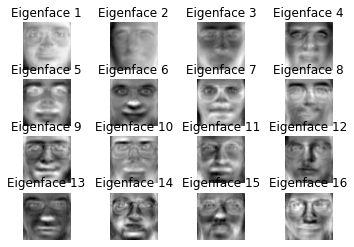

In [60]:
for i in range(min(K, 16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(eigenvectors[:,i].reshape(height, width), cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.axis('off')

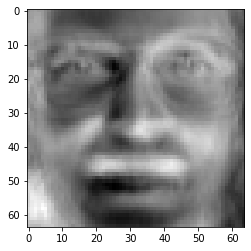

In [61]:
# ------------------------ SHOW A RANDOM EIGENFACE ------------------------ #

# index = int(random.random() * m)
index = 10
plt.imshow(eigenvectors[:,index].reshape(height, width), cmap='gray')
plt.show()

In [62]:
# ------------------------ CALCULATE OMEGAS ------------------------ #

omegas = []
for image in difference_images.T:
    omegas.append(np.dot(image, eigenvectors))
omegas = np.array(omegas)
print('Shape of omegas:', omegas.shape)

Shape of omegas: (320, 111)


## Testing

In [72]:
# -------------------------------------- TESTING SINGLE IMAGE -------------------------------------- #

# index = int(random.random() * test_images.shape[0])
index = 0
test_image = flattened_test_images[:,index, np.newaxis]
# N^2 * 1
print(f'Test image has shape: {test_image.shape}')


min_distance = float('inf')
nearest_person = -1

omega_image = np.matmul((test_image - average_image).T, eigenvectors)


for i in range(m):
    omega = omegas[i]
    distance = np.linalg.norm(omega_image - omega)
    if distance < min_distance:
        min_distance = distance
        nearest_person = i

print(f'Nearest person is {nearest_person} with distance {min_distance}')

if (y_train[nearest_person] == y_test[index]):
    print('Correct')
else:
    print('Incorrect')


Test image has shape: (4096, 1)
Nearest person is 270 with distance 4.2090349197387695
Correct


In [76]:
# ---------------------------- TESTING ACCURACY ---------------------------- #
count = 0
trials = 1000
for trial in range(trials):
    # Get test image index randomly
    index = int(random.random() * m_test)
    
    # Get image
    test_image = flattened_test_images[:,index, np.newaxis]

    min_distance = float('inf')
    nearest_person = -1


    omega_image = np.matmul((test_image - average_image).T, eigenvectors)

    for i in range(m):
        omega = omegas[i]
        distance = np.linalg.norm(omega_image - omega)
        if distance < min_distance:
            min_distance = distance
            nearest_person = i

    
    threshold = float('inf')
    if (min_distance < threshold):
        if(y_train[nearest_person] == y_test[index]):
            count += 1
print(f'Accuracy: {count/trials*100}%')

Accuracy: 87.7%
